# Wavelet filtering 

author: steeve.laquitaine@epfl.ch

* objective:
    * to get a comprehensive description of the frequency components of the traces 
    * we need a power spectrum with a frequency resolution that is informed on the functionnally relevant frequencies identified by past studies. The slowest waves documented are the infra slow waves, which oscillate below 0.1 Hz, so we choose this resolution.

* observations:
    * wavelet filtering removes nearly all the high frequency noise and make spike apparent, compared with butterworth filtering, from which spikes remain invisible.

### Setup

activate spikeinterf..

In [36]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
from concurrent.futures import ProcessPoolExecutor
from scipy.signal import detrend
from sklearn.preprocessing import MinMaxScaler
from pywt import Wavelet, threshold
import pywt
from matplotlib import pyplot as plt
from scipy import signal
import spikeinterface.full as si
import spikeinterface.extractors as se 

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
matplotlib.rcParams['agg.path.chunksize'] = 10000

# SETUP PARAMETERS

# - selected site
L5_SITE = 256  # site in layer 5

# - trace
SFREQ = 30000       # sampling frequency
nyquist = SFREQ / 2
duration_secs = 1215 # 4*60 #4 mins

# - filtering
WAVELET = "haar"
NLEVEL = 6       # produces a high-pass filter cutoff of 234.375 Hz
THRESH = "han"
THRESH_METHOD = "hard"
RECON_MODE = "zero"

# - PSD
#FILT_WIND_SIZE = 512500 #2300  # tuned to get a freq. resol. of 0.1 Hz
FILT_WIND_SIZE = 30000 #5125*6   #2300  # tuned to get a freq. resol. of 0.1 Hz
FILT_WIND_OVERLAP = int(FILT_WIND_SIZE // 1.5) #// 2 # overlap raises computational cost.
FILT_WINDOW = 'hann'

# butterworth filtering
FREQ_MIN = 234.375

# SETUP DATASET COMFIG
# vivo
data_conf_vivo, param_conf_h_vivo = get_config("vivo_marques", "c26").values()
RAW_PATH_vivo = data_conf_vivo["probe_wiring"]["output"]
PREP_PATH_vivo = data_conf_vivo["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_vivo = data_conf_vivo["postprocessing"]["trace_snr"]
POWER_RAW_vivo = data_conf_vivo["analyses"]["traces"]["power"]["raw"]
POWER_PREP_vivo = data_conf_vivo["analyses"]["traces"]["power"]["preprocessed"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-05-03 16:14:15,933 - root - utils.py - get_config - INFO - Reading experiment config.
2024-05-03 16:14:15,972 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Define custom functions

In [6]:
def NearestEvenInteger(n):
    """! Returns the nearest even integer to number n.

    @param n Input number for which one requires the nearest even integer

    @return The even nearest integer to the input number
    """
    if n % 2 == 0:
        res = n
    else:
        res = n - 1
    return res


def std(trace, nlevel=6):
    """Estimates the standard deviation of the input trace for rescaling
    the Wavelet's coefficients.

    Returns
        Standard deviation of the input trace as (1D ndarray)
    """
    sigma = np.array([1.4825 * np.median(np.abs(trace[i])) for i in range(nlevel)])
    return sigma


def get_han_threshold(trace: np.array, sigma: np.array, coeffs: np.array, nlevels: int):

    # count samples
    num_samples = len(trace)

    # han et al threshold
    details_threshs = np.array([np.nan] * len(coeffs[1:]))

    # threshold for first detail coeff d_i=0
    details_threshs[0] = sigma[1] * np.sqrt(2 * np.log(num_samples))

    # threshold from 1 < d_i < NLEVELS
    for d_i in range(1, nlevels - 1):
        details_threshs[d_i] = (sigma[d_i] * np.sqrt(2 * np.log(num_samples))) / np.log(
            d_i + 1
        )
    # threhsold for d_i = nlevels
    details_threshs[nlevels - 1] = (
        sigma[nlevels - 1] * np.sqrt(2 * np.log(num_samples))
    ) / np.sqrt(nlevels - 1)
    return details_threshs

### (2.5s) Load recordings

(27s) 36,450,000 samples (total duration of 1215 secs)

In [7]:
# load raw traces
RawVivo = si.load_extractor(RAW_PATH_vivo)

# get one "good" site in cortex
trace = RawVivo.get_traces(channel_ids=[L5_SITE], end_frame=SFREQ * duration_secs)
trace = np.array(trace).flatten()

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/binaryrecordingextractor.py:78: UserWarning: `num_chan` is to be deprecated in version 0.100, please use `num_channels` instead
  warnings.warn("`num_chan` is to be deprecated in version 0.100, please use `num_channels` instead")


### (.1s) Describe

In [11]:
duration_secs = len(trace) / SFREQ
num_samples = len(trace)
print("duration:", duration_secs, "secs")
print("number of samples:", num_samples)
print("total duration:", RawVivo.get_total_duration(), "secs")
trace

duration: 1215.0 secs
number of samples: 36450000
total duration: 1215.0512666666666 secs


array([43, 42, 46, ...,  1, -3, -4], dtype=int16)

### Wavelet Filtering

#### (.1s) Parametrize
 
$$F_c = N_q/2^{NLEVEL}$$

A decomposition level of 6 produces an frequency cutoff of Fc = 234.375 Hz.

In [12]:
# calculate cutoff frequency
freq_cutoff = nyquist / 2**NLEVEL  # cutoff frequency (the max of lowest freq. band)
print("Cutoff frequency for high-pass filtering :", freq_cutoff, "Hz")

Cutoff frequency for high-pass filtering : 234.375 Hz


#### (.7s) Preprocess

In [13]:
# detrend
detrended = detrend(trace)

# normalize data
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
detrended = scaler.fit_transform(detrended.reshape(-1, 1))[:, 0]
normalized = detrended.copy()

#### (.4s) Wavelet transform

In [14]:
# make sure number of samples is a multiple of 2**NLEVEL
size = (normalized.shape[0] // 2**NLEVEL) * (2**NLEVEL)
print("number of samples used for decomposition:", size)

# initialize filter
wavelet = Wavelet(WAVELET)

# translation-invariance modification of the Discrete Wavelet Transform
# that does not decimate coefficients at every transformation level.
coeffs = pywt.swt(
    normalized[:size], wavelet, level=NLEVEL, start_level=0, trim_approx=True
)
coeffs_raw = coeffs.copy()

# print approximation and details coefficients
print("approximation coefficients:", coeffs_raw[0])
print("details coefficients:", coeffs_raw[1:])

number of samples used for decomposition: 36449984
approximation coefficients: [6.10502383 6.10421791 6.10341198 ... 6.00786584 6.03917726 6.07129461]
details coefficients: [array([ 0.08301093,  0.09832364,  0.10718889, ..., -0.04154875,
       -0.00862547,  0.0363868 ]), array([-0.01139764, -0.02165548, -0.02051572, ..., -0.15677809,
       -0.09084161, -0.05453891]), array([-0.00483561,  0.00161185,  0.02901355, ..., -0.20237529,
       -0.14297619, -0.06584657]), array([ 0.03875185,  0.04786993,  0.02507472, ..., -0.34318988,
       -0.24550974, -0.13187295]), array([-0.05157966, -0.04190848,  0.04190847, ..., -0.13491685,
       -0.28595235, -0.15425923]), array([ 4.55904069e-03, -1.82361654e-02, -4.10313714e-02, ...,
       -5.18920740e-10,  9.11808190e-03, -2.09037407e-01])]


#### (.8s) Denoise

In [15]:
# estimate the wavelet coefficients standard deviations
sigma = std(coeffs[1:], nlevel=NLEVEL)

# determine the thresholds of the coefficients per level ('han')
threshs = get_han_threshold(
    trace=trace,
    sigma=sigma,
    coeffs=coeffs,
    nlevels=NLEVEL,
)

# apply the thresholds to the detail coeffs
coeffs[1:] = [
    threshold(coeff_i, value=threshs[i], mode=THRESH_METHOD)
    for i, coeff_i in enumerate(coeffs[1:])
]

#### (.8s) High-pass filter

In [16]:
# clear approximation coefficients (set to 0)
coeffs[0] = np.zeros(len(coeffs[0]))

# sanity check
assert sum(coeffs[0]) == 0, "not cleared"

#### (2s) Reconstruct and reverse-normalize

In [17]:
# reconstruct and reverse normalize
denoised_trace = pywt.iswt(coeffs, wavelet)
denoised_trace = scaler.inverse_transform(denoised_trace.reshape(-1, 1))[:, 0]

# remove DC component
denoised_trace -= np.mean(denoised_trace)

### Butterworth filtering

In [15]:
# make a RecordingExtractor
trace_buttw = se.NumpyRecording(
    traces_list=[np.array([trace]).T],
    sampling_frequency=SFREQ,
)

# high-pass filter
butterworth_denoised = si.bandpass_filter(
    trace_buttw, freq_min=FREQ_MIN, freq_max=nyquist - 1
)

### (.6s) Plot

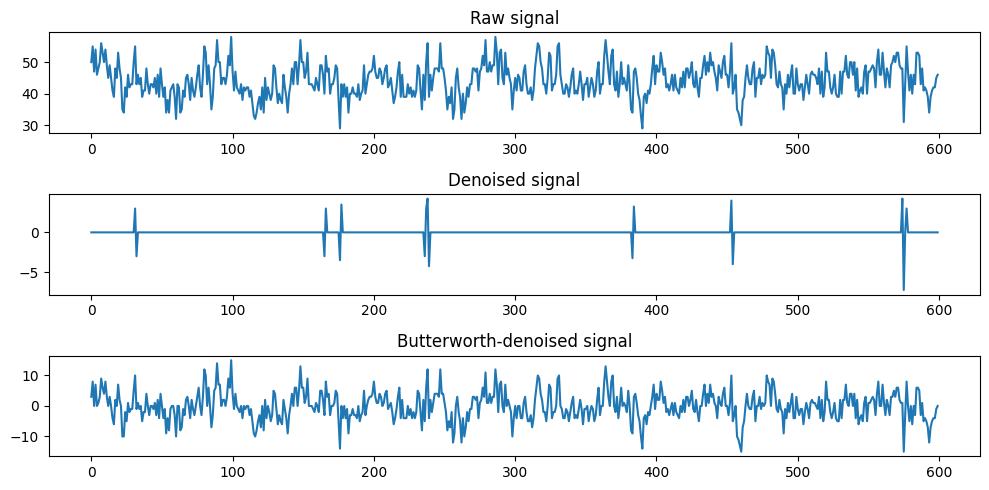

In [16]:
fig = plt.figure(figsize=(10, 5))

# raw
ax = fig.add_subplot(311)
ax.plot(trace[200:800])
ax.set_title("Raw signal")

# denoised
ax = fig.add_subplot(312)
ax.plot(denoised_trace[200:800])
ax.set_title("Denoised signal")

# denoised
ax = fig.add_subplot(313)
ax.plot(butterworth_denoised.get_traces()[200:800])
ax.set_title("Butterworth-denoised signal")

plt.tight_layout()

#### Zoom in 

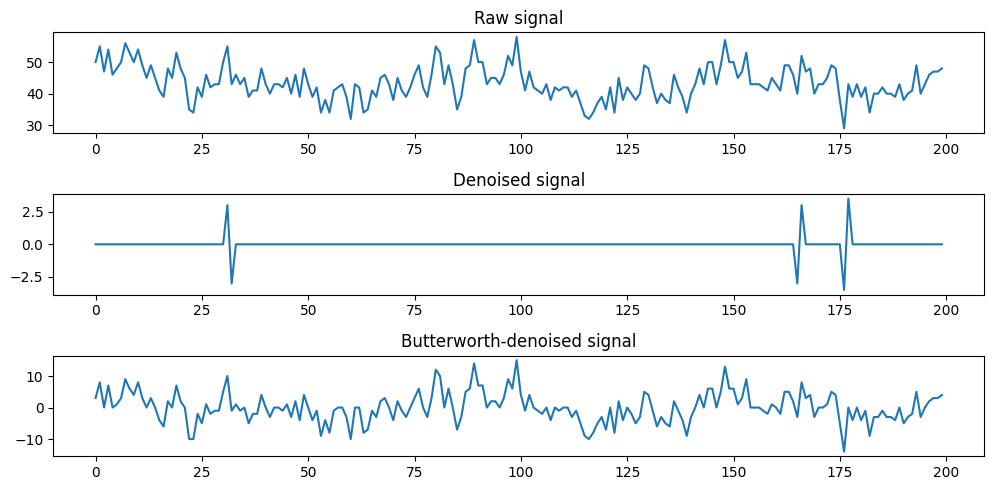

In [17]:
fig = plt.figure(figsize=(10, 5))

# raw
ax = fig.add_subplot(311)
ax.plot(trace[200:400])
ax.set_title("Raw signal")

# denoised
ax = fig.add_subplot(312)
ax.plot(denoised_trace[200:400])
ax.set_title("Denoised signal")

# denoised
ax = fig.add_subplot(313)
ax.plot(butterworth_denoised.get_traces()[200:400])
ax.set_title("Butterworth-denoised signal")

plt.tight_layout()

### (2.2s) Power spectral density

#### (5s) Check Welch's frequency resolution

In [37]:
# Welch method
freqs, powers = signal.welch(
    trace[:size],
    SFREQ,
    window=FILT_WINDOW,
    nperseg=FILT_WIND_SIZE,
    noverlap=FILT_WIND_OVERLAP,
)
print("Welch freq. resolution:", np.sort(freqs)[1] - np.sort(freqs)[0])
print("The upper bound freq. resolution (Fourier's):", SFREQ / trace.shape[0])

Welch freq. resolution: 1.0
The upper bound freq. resolution (Fourier's): 0.0008230452674897119


#### (40s) Plot wavelet denoised PSD

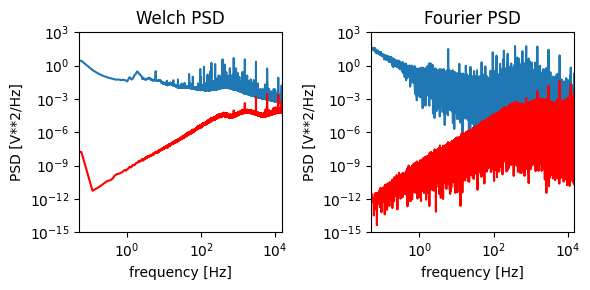

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

YLIM_W = [1e-15, 1e3]
YLIM_F = [1e-15, 1e3]
XLIM = [0.05, SFREQ / 2]

# (4.7s) Welch method
freqs, powers = signal.welch(
    trace[:size],
    SFREQ,
    window=FILT_WINDOW,
    nperseg=FILT_WIND_SIZE,
    noverlap=FILT_WIND_OVERLAP,
)
axes[0].plot(freqs, powers)
axes[0].semilogy(basex=10)
axes[0].semilogx(basey=10)
axes[0].set_ylim(YLIM_W)
axes[0].set_xlim(XLIM)
axes[0].set_xlabel("frequency [Hz]")
axes[0].set_ylabel("PSD [V**2/Hz]")

# Welch method
freqs, powers = signal.welch(
    denoised_trace[:size],
    SFREQ,
    window=FILT_WINDOW,
    nperseg=FILT_WIND_SIZE,
    noverlap=FILT_WIND_OVERLAP,
)
axes[0].plot(freqs, powers, "r")
axes[0].semilogy(basex=10)
axes[0].semilogx(basey=10)
axes[0].set_ylim(YLIM_W)
axes[0].set_xlim(XLIM)
axes[0].set_xlabel("frequency [Hz]")
axes[0].set_ylabel("PSD [V**2/Hz]")
axes[0].set_title("Welch PSD")

# Fourier psd
freqs, powers = signal.periodogram(
    trace[:size],
    fs=SFREQ,
    window="boxcar",
    nfft=None,
    detrend="constant",
    return_onesided=True,
    scaling="density",
    axis=-1,
)

axes[1].plot(freqs, powers)
axes[1].semilogy(basex=10)
axes[1].semilogx(basey=10)
axes[1].set_ylim(YLIM_F)
axes[1].set_xlim(XLIM)
axes[1].set_xlabel("frequency [Hz]")
axes[1].set_ylabel("PSD [V**2/Hz]")

# preprocessed
freqs, powers = signal.periodogram(
    denoised_trace[:size],
    fs=SFREQ,
    window="boxcar",
    nfft=None,
    detrend="constant",
    return_onesided=True,
    scaling="density",
    axis=-1,
)

axes[1].plot(freqs, powers, "r")
axes[1].semilogy(basex=10)
axes[1].semilogx(basey=10)
axes[1].set_ylim(YLIM_F)
axes[1].set_xlim(XLIM)
axes[1].set_xlabel("frequency [Hz]")
axes[1].set_ylabel("PSD [V**2/Hz]")
axes[1].set_title("Fourier PSD")

#### Butterworth denoised PSD

Text(0.5, 1.0, 'Fourier PSD')

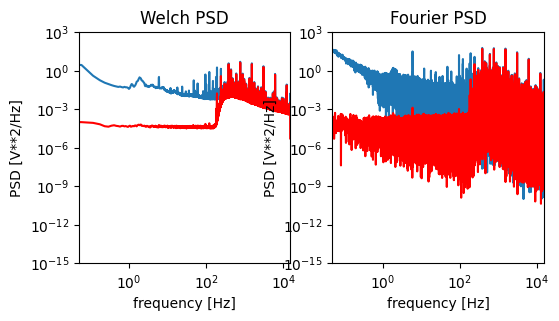

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

YLIM_W = [1e-15, 1e3]
YLIM_F = [1e-15, 1e3]
XLIM = [0.05, SFREQ / 2]

# (4.7s) Welch method
freqs, powers = signal.welch(
    trace[:size],
    SFREQ,
    window=FILT_WINDOW,
    nperseg=FILT_WIND_SIZE,
    noverlap=FILT_WIND_OVERLAP,
)
axes[0].plot(freqs, powers)
axes[0].semilogy(basex=10)
axes[0].semilogx(basey=10)
axes[0].set_ylim(YLIM_W)
axes[0].set_xlim(XLIM)
axes[0].set_xlabel("frequency [Hz]")
axes[0].set_ylabel("PSD [V**2/Hz]")

# Welch method
freqs, powers = signal.welch(
    butterworth_denoised.get_traces()[:size, 0],
    SFREQ,
    window=FILT_WINDOW,
    nperseg=FILT_WIND_SIZE,
    noverlap=FILT_WIND_OVERLAP,
)
axes[0].plot(freqs, powers, "r")
axes[0].semilogy(basex=10)
axes[0].semilogx(basey=10)
axes[0].set_ylim(YLIM_W)
axes[0].set_xlim(XLIM)
axes[0].set_xlabel("frequency [Hz]")
axes[0].set_ylabel("PSD [V**2/Hz]")
axes[0].set_title("Welch PSD")

# Fourier psd
freqs, powers = signal.periodogram(
    trace[:size],
    fs=SFREQ,
    window="boxcar",
    nfft=None,
    detrend="constant",
    return_onesided=True,
    scaling="density",
    axis=-1,
)

axes[1].plot(freqs, powers)
axes[1].semilogy(basex=10)
axes[1].semilogx(basey=10)
axes[1].set_ylim(YLIM_F)
axes[1].set_xlim(XLIM)
axes[1].set_xlabel("frequency [Hz]")
axes[1].set_ylabel("PSD [V**2/Hz]")

# preprocessed
freqs, powers = signal.periodogram(
    butterworth_denoised.get_traces()[:size, 0],
    fs=SFREQ,
    window="boxcar",
    nfft=None,
    detrend="constant",
    return_onesided=True,
    scaling="density",
    axis=-1,
)

axes[1].plot(freqs, powers, "r")
axes[1].semilogy(basex=10)
axes[1].semilogx(basey=10)
axes[1].set_ylim(YLIM_F)
axes[1].set_xlim(XLIM)
axes[1].set_xlabel("frequency [Hz]")
axes[1].set_ylabel("PSD [V**2/Hz]")
axes[1].set_title("Fourier PSD")

# References

(1) https://github.com/steevelaquitaine/wavelet_denoise/blob/master/notebooks/wavelet_denoising.ipynb

(2) Wiltschko, Gage, and Berke, “Wavelet Filtering before Spike Detection Preserves Waveform Shape and Enhances Single-Unit Discrimination.” J Neurosci Methods (2008).

(3) Baldazzi et al., “Systematic Analysis of Wavelet Denoising Methods for Neural Signal Processing.”, Journal of Neural Engineering (2020)